<a href="https://colab.research.google.com/github/manish2021iitd/Deep-Learning/blob/main/DLassignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4422102/4422102 [==============================] - 0s 0us/step


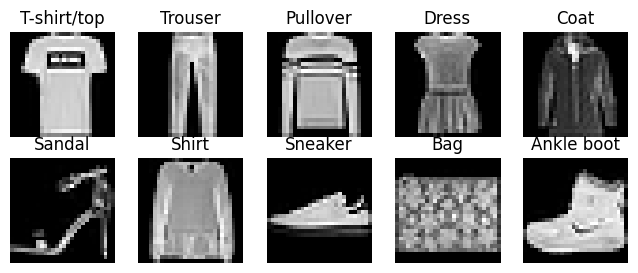

In [3]:
#Q1
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load Fashion-MNIST dataset
(training_images, training_labels), (testing_images,testing_labels) = fashion_mnist.load_data()

# Plot one sample image for each class
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(training_images[training_labels == i][0], cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.show()


In [4]:
#Q2
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size #number of inputs nodes
        self.hidden_sizes = hidden_sizes #list of neurons in each hidden layer
        self.output_size = output_size #number of output neurons in output layer
        self.weights = [] #list of weight matrices for each layer
        self.biases = []  #list of bias vectors for each hidden layer and output layer

        #innitializing the weights and biases for each layer
        sizes = [input_size] + hidden_sizes + [output_size] #using list concatination to make a list of number of nodes in each layer
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i+1], sizes[i]))
            self.biases.append(np.random.randn(sizes[i+1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
      # Forward pass
      activations = [X]
      for i in range(len(self.weights)):
        z = np.dot(activations[-1], self.weights[i].T) + self.biases[i]  # Transpose weight matrix
        a = self.sigmoid(z) if i < len(self.weights) - 1 else self.softmax(z)
        activations.append(a)
      return activations

    def predict(self, X):
        #predict output probabilities
        activations = self.forward(X)
        return activations[-1]

#load fashion-mnist dataset
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#define neural network
input_size = X_train.shape[1]  #28x28 images flattened
hidden_sizes = [128, 64]  #size of hidden layers
output_size = 10  # 10 classes in fashion-mnist

#initialize neural network
model = NeuralNetwork(input_size, hidden_sizes, output_size)

#predict probabilities for the test set
probabilities = model.predict(X_test)

#print the output probabilities
print("Output Probabilities:", probabilities)

Output Probabilities: [[9.01490897e-03 3.29127908e-03 4.10224864e-02 ... 2.48694513e-01
  3.21784631e-02 7.32184604e-04]
 [3.39104918e-01 1.32987067e-03 1.41483443e-04 ... 1.04984767e-03
  1.36490678e-04 3.27866023e-03]
 [7.79620447e-05 2.05533719e-03 5.26934570e-04 ... 2.95792288e-05
  1.18830973e-04 3.16500202e-05]
 ...
 [1.51491871e-03 1.09465295e-02 1.02829645e-02 ... 6.56370874e-03
  6.22244228e-02 1.51639659e-05]
 [2.03394459e-05 1.16446999e-03 6.98837973e-03 ... 1.89181325e-05
  1.04977374e-04 3.29145420e-05]
 [1.45428690e-03 2.19035859e-03 4.51465040e-01 ... 5.29991994e-03
  7.93807848e-05 1.69068504e-02]]


In [28]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.weights = []
        self.biases = []

        #initialize weights and biases for each layer
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i+1], sizes[i]))
            self.biases.append(np.random.randn(sizes[i+1],1))

        #initialize velocities for momentum-based optimization
        self.velocities = [np.zeros_like(w) for w in self.weights]

        #initialize rmsprop parameters
        self.rmsprop_cache_w = [np.zeros_like(w) for w in self.weights]
        self.rmsprop_cache_b = [np.zeros_like(b) for b in self.biases]

        #initialize adam parameters
        self.adam_m_w = [np.zeros_like(w) for w in self.weights]
        self.adam_m_b = [np.zeros_like(b) for b in self.biases]
        self.adam_v_w = [np.zeros_like(w) for w in self.weights]
        self.adam_v_b = [np.zeros_like(b) for b in self.biases]

    def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))

    def d_sigmoid(self,x):
      return self.sigmoid(x)*(1-self.sigmoid(x))

    def softmax(self, x):
      exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
      return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def logloss(self, y, y_label):
      error = -(y_label*np.log(y+1e-10)+(1-y_label)*np.log(1-y+1e-10))
      return np.sum(error, axis = 0)/error.shape[0]

    def Cross_entropy(self, y, y_hat):
      da = (1-y)/(1-y_hat) - (y)/(y_hat+1e-10)
      epoch_loss = self.__logloss(y_hat, y)
      return da, epoch_loss

    #forwardpropagation
    def forward(self, X):
      activations = [X] #create a list of all activations
      for i in range(len(self.weights)):
        z = np.dot(self.weights[i],activations[-1].T) + self.biases[i]  #preactivation
        a = self.sigmoid(z) if i < len(self.weights) - 1 else self.softmax(z) #activation/output
        activations.append(a) #appending the activations list
      return activations

    #backwardpropagation
    def backward(self, y, activations):
        delta = activations[-1] - y
        for i in range(len(self.weights) - 1, -1, -1):
            dz = delta * (activations[i+1] * (1 - activations[i+1])) if i < len(self.weights) - 1 else delta
            dw = np.dot(dz.T, activations[i])
            db = np.sum(dz, axis=0)
            delta = np.dot(dz, self.weights[i])
        return dw,db


    def update(self, X, y, optimizer, epochs, learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8):
      for _ in range(epochs):
        activations = self.forward(X)
        dw, db = self.backward(y, activations)

        if optimizer == 'sgd':
          for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dw[i]
            self.biases[i] -= learning_rate * db[i]

        elif optimizer == 'momentum':
          for i in range(len(self.weights)):
            self.velocities[i] = beta1 * self.velocities[i] + (1 - beta1) * dw[i]
            self.weights[i] -= learning_rate * self.velocities[i]
            self.biases[i] -= learning_rate * db[i]

        elif optimizer == 'nesterov':
          lookahead_weights = [w - beta1 * v for w, v in zip(self.weights, self.velocities)]
          lookahead_biases = [b - beta1 * v[-1] for b, v in zip(self.biases, self.velocities)]
          lookahead_activations = self.forward(X)
          lookahead_dw, lookahead_db = self.backward(y, lookahead_activations)
          for i in range(len(self.weights)):
            self.velocities[i] = beta1 * self.velocities[i] + (1 - beta1) * lookahead_dw[i]
            self.weights[i] -= learning_rate * self.velocities[i]
            self.biases[i] -= learning_rate * lookahead_db[i]

        elif optimizer == 'rmsprop':
          for i in range(len(self.weights)):
            self.rmsprop_cache_w[i] = beta1 * self.rmsprop_cache_w[i] + (1 - beta1) * dw[i]**2
            self.rmsprop_cache_b[i] = beta1 * self.rmsprop_cache_b[i] + (1 - beta1) * db[i]**2
            self.weights[i] -= learning_rate * dw[i] / (np.sqrt(self.rmsprop_cache_w[i]) + epsilon)
            self.biases[i] -= learning_rate * db[i] / (np.sqrt(self.rmsprop_cache_b[i]) + epsilon)

        elif optimizer == 'adam':
          for i in range(len(self.weights)):
            self.adam_m_w[i] = beta1 * self.adam_m_w[i] + (1 - beta1) * dw[i]
            self.adam_m_b[i] = beta1 * self.adam_m_b[i] + (1 - beta1) * db[i]
            self.adam_v_w[i] = beta2 * self.adam_v_w[i] + (1 - beta2) * dw[i]**2
            self.adam_v_b[i] = beta2 * self.adam_v_b[i] + (1 - beta2) * db[i]**2
            m_w_hat = self.adam_m_w[i] / (1 - beta1**(i+1))
            m_b_hat = self.adam_m_b[i] / (1 - beta1**(i+1))
            v_w_hat = self.adam_v_w[i] / (1 - beta2**(i+1))
            v_b_hat = self.adam_v_b[i] / (1 - beta2**(i+1))
            self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

        elif optimizer == 'nadam':
          for i in range(len(self.weights)):
            self.adam_m_w[i] = beta1 * self.adam_m_w[i] + (1 - beta1) * dw[i]
            self.adam_m_b[i] = beta1 * self.adam_m_b[i] + (1 - beta1) * db[i]
            self.adam_v_w[i] = beta2 * self.adam_v_w[i] + (1 - beta2) * dw[i]**2
            self.adam_v_b[i] = beta2 * self.adam_v_b[i] + (1 - beta2) * db[i]**2
            m_w_hat = self.adam_m_w[i] / (1 - beta1**(i+1))
            m_b_hat = self.adam_m_b[i] / (1 - beta1**(i+1))
            v_w_hat = self.adam_v_w[i] / (1 - beta2**(i+1))
            v_b_hat = self.adam_v_b[i] / (1 - beta2**(i+1))
            self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)


    def train(self, X, y, optimizer, epochs, batch_size):
      #train the neural network using different optimizers
      for epoch in range(epochs):
        for i in range(0, len(X), batch_size):
          X_batch = X[i:i+batch_size]
          y_batch = y[i:i+batch_size]
          self.update(X_batch,y_batch,optimizer,epochs)

    def test(self, X):
      activations = self.forward(X)
      return activations[-1]


#load fashion-mnist dataset
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
#define neural network
input_size = 784#size of inputs
hidden_sizes = [128, 64]  #size of neurons in each hidden layers
output_size = 10  #taking 10 output neurons as we have classify 10 classes in fashion-mnist

# Convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

#initialize neural network
model = NeuralNetwork(input_size, hidden_sizes, output_size)

#please choose optimizer = 'sgd'/'momentum'/'nesterov'/'rmsprop'/'adam'/'nadam'
#and number of epochs and batch size here
model.train(X_train, y_train_one_hot,'nadam', epochs=10, batch_size=32)

results = model.test(X_test)

results = np.argmax(results, axis=-1)
real_labels = np.argmax(y_test, axis=-1)
accuracy = sum(1*(results==real_labels))/len(results)
print("The accuracy of testing is ", accuracy*100, "%")
#References:
#1.https://cs229.stanford.edu/main_notes.pdf
#2.http://www.cse.iitm.ac.in/~miteshk/CS6910.html
#3.https://visualstudiomagazine.com/Articles/2017/06/01/Back-Propagation.aspx?Page=2
#4.https://medium.com/@ipylypenko/exploring-neural-networks-with-fashion-mnist-b0a8214b7b7b
#5.https://www.youtube.com/watch?v=Wo5dMEP_BbI&list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3
#7.https://www.youtube.com/watch?v=LQvRhQwDOm0

(60000, 784)


ValueError: shapes (64,128) and (32,128) not aligned: 128 (dim 1) != 32 (dim 0)

In [1]:
import numpy as np
from keras.datasets import fashion_mnist

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.weights = []
        self.biases = []

        # Initialize weights and biases for each layer
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i+1], sizes[i]))
            self.biases.append(np.random.randn(sizes[i+1]))

        # Initialize velocities for momentum-based optimization
        self.velocities = [np.zeros_like(w) for w in self.weights]

        # Initialize rmsprop parameters
        self.rmsprop_cache_w = [np.zeros_like(w) for w in self.weights]
        self.rmsprop_cache_b = [np.zeros_like(b) for b in self.biases]

        # Initialize adam parameters
        self.adam_m_w = [np.zeros_like(w) for w in self.weights]
        self.adam_m_b = [np.zeros_like(b) for b in self.biases]
        self.adam_v_w = [np.zeros_like(w) for w in self.weights]
        self.adam_v_b = [np.zeros_like(b) for b in self.biases]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def logloss(self, y, y_label):
        error = -(y_label * np.log(y + 1e-10) + (1 - y_label) * np.log(1 - y + 1e-10))
        return np.sum(error, axis=0) / error.shape[0]

    def Cross_entropy(self, y, y_hat):
        da = (1 - y) / (1 - y_hat) - (y) / (y_hat + 1e-10)
        epoch_loss = self.logloss(y_hat, y)
        return da, epoch_loss

    # Forward propagation
    def forward(self, X):
        activations = [X] # Create a list of all activations
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i].T) + self.biases[i]  # Preactivation
            a = self.sigmoid(z) if i < len(self.weights) - 1 else self.softmax(z) # Activation/output
            activations.append(a) # Append the activations list
        return activations

    # Backward propagation
    def backward(self, y, activations):
        delta = activations[-1] - y
        for i in range(len(self.weights) - 1, -1, -1):
            dz = delta * (activations[i+1] * (1 - activations[i+1])) if i < len(self.weights) - 1 else delta
            dw = np.dot(dz.T, activations[i])
            db = np.sum(dz, axis=0)
            delta = np.dot(dz, self.weights[i])
        return dw, db

    def optimizer(self, X, y, optimizer, epochs, learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        for _ in range(epochs):
            activations = self.forward(X)
            dw, db = self.backward(y, activations)

            if optimizer == 'sgd':
                self.weights -= learning_rate * dw
                self.biases -= learning_rate * db
            elif optimizer == 'momentum':
                self.velocities = beta1 * np.array(self.velocities) + (1 - beta1) * dw
                self.weights -= learning_rate * np.array(self.velocities)
                self.biases -= learning_rate * db
            elif optimizer == 'rmsprop':
                self.rmsprop_cache_w = beta1 * np.array(self.rmsprop_cache_w) + (1 - beta1) * dw**2
                self.rmsprop_cache_b = beta1 * np.array(self.rmsprop_cache_b) + (1 - beta1) * db**2
                self.weights -= learning_rate * dw / (np.sqrt(self.rmsprop_cache_w) + epsilon)
                self.biases -= learning_rate * db / (np.sqrt(self.rmsprop_cache_b) + epsilon)
            elif optimizer == 'adam':
                self.adam_m_w = beta1 * np.array(self.adam_m_w) + (1 - beta1) * dw
                self.adam_m_b = beta1 * np.array(self.adam_m_b) + (1 - beta1) * db
                self.adam_v_w = beta2 * np.array(self.adam_v_w) + (1 - beta2) * dw**2
                self.adam_v_b = beta2 * np.array(self.adam_v_b) + (1 - beta2) * db**2
                m_w_hat = self.adam_m_w / (1 - beta1**(i+1))
                m_b_hat = self.adam_m_b / (1 - beta1**(i+1))
                v_w_hat = self.adam_v_w / (1 - beta2**(i+1))
                v_b_hat = self.adam_v_b / (1 - beta2**(i+1))
                self.weights -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
                self.biases -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

    def train(self, X, y, optimizer, epochs, batch_size):
        # Train the neural network using different optimizers
        for epoch in range(epochs):
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                self.optimizer(X_batch, y_batch, optimizer, epochs)

    def test(self, X):
        activations = self.forward(X)
        return activations[-1]

# Load fashion-mnist dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

# Initialize neural network
input_size = X_train.shape[1]  # Size of inputs
hidden_sizes = [128, 64]  # Size of neurons in each hidden layer
output_size = 10  # Taking 10 output neurons as we have to classify 10 classes in fashion-mnist
model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Choose optimizer and other parameters
optimizer = 'sgd'  # You can choose 'momentum', 'rmsprop', 'adam', etc.
epochs = 10
batch_size = 32

# Train the model
model.train(X_train, y_train_one_hot, optimizer, epochs, batch_size)

# Test the model
results = model.test(X_test)

results = np.argmax(results, axis=-1)
real_labels = np.argmax(y_test_one_hot, axis=-1)
accuracy = sum(1*(results==real_labels))/len(results)
print("The accuracy of testing is ", accuracy*100, "%")


4422102/4422102 [==============================] - 0s 0us/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.